In [127]:
from gurobipy import *
import networkx as nx
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

In [128]:
def draw_reduced(g, color_map = None):
    node_lables = nx.get_node_attributes(g, "weight")
    node_lables = {k: "{0}: {1}".format(k, v) for (k, v) in node_lables.items()}
    
    plt.figure()
    cpos = nx.circular_layout(g)
    nx.draw(g, cpos, node_size=2000, width = 1, node_color = color_map)
    nx.draw_networkx_labels(g, cpos, node_lables)
    plt.show()  
    # plt.savefig("graph.png", dpi=1000)


In [129]:
def compute_max_ind_set(graph, display = False):
    nodes = list(graph.nodes)
    model = Model('Maximum Independent Set')
    model.setParam('OutputFlag', 0)
    # An indicator variable for whether a node is chosen
    indicators = model.addVars(nodes, vtype=GRB.BINARY, name = "x")
    
    # Set Constraint: If two nodes are bound by an edge, they cannot be both chosen
    model.addConstrs(((indicators[i] + indicators[j] <= 1) for (i, j) in graph.edges), "Max")
    
    # Set objective: Maximize the weighted sum of nodes
    weights = nx.get_node_attributes(graph, "weight")
    
    obj = sum([indicators[i] * weights[i] for i in nodes])
    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    
    # Aggregate all the nodes that have been chosen
    soln = []
    for i in range(len(indicators)):
        if indicators[i].x != 0:
            soln.append(i)
    if display:
        color_map = ["grey"] * len(graph.nodes)
        for i in soln:
            color_map[i] = "green"
        draw_reduced(graph, color_map)
    return soln


    

In [130]:
# Generate a random sparse graph and assign random weights to each vertex


rand_graph = nx.fast_gnp_random_graph(10, 0.4, directed=False)

for v in rand_graph.nodes():
    rand_graph.nodes[v]['weight'] = round(random.uniform(0, 1), 2)
    
# draw_reduced(rand_graph)

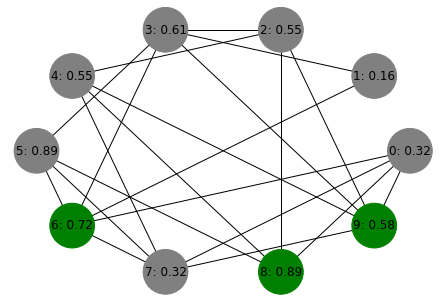

In [131]:
rand_output = compute_max_ind_set(rand_graph, display=True)

In [132]:
rand_output

[6, 8, 9]